<a href="https://colab.research.google.com/github/karou1182001/NLPAssignments/blob/main/Assignment3/Intro_to_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 3: Intro to Recurrent Neural Networks: Math, Training, and the Copy Task

# Instructor: Dr. Ankur Mali
# University of South Florida (Spring 2025)
### In this tutorial we will build RNNs based on equation and will compare 3 popular frameworks (Jax, TensorFlow and Pytorch)

## Vanilla RNN -- For more in depth explanation refer to your slides

### Forward Pass (Inference) -- Stage 1
Given an input at time \(t\):
\begin{aligned}
\mathbf{x}_t \in \mathbb{R}^{d_{\text{in}}},\quad \mathbf{h}_{t-1} \in \mathbb{R}^{d_{\text{hid}}}
\end{aligned}
we define RNN parameters:
\begin{aligned}
\mathbf{W}_x \in \mathbb{R}^{d_{\text{in}} \times d_{\text{hid}}}, \quad
\mathbf{W}_h \in \mathbb{R}^{d_{\text{hid}} \times d_{\text{hid}}}, \quad
\mathbf{b}_h \in \mathbb{R}^{d_{\text{hid}}}.
\end{aligned}

The hidden state update:
\begin{aligned}
\mathbf{h}_t = \tanh\Bigl(\mathbf{x}_t\,\mathbf{W}_x \;+\;\mathbf{h}_{t-1}\,\mathbf{W}_h \;+\;\mathbf{b}_h\Bigr).
\end{aligned}

Over a sequence  ($\mathbf{x}_1$, $\dots$, $\mathbf{x}_T$), we unroll:
\begin{aligned}
\mathbf{h}_0 = \mathbf{0},\quad
\mathbf{h}_1 = \tanh(\mathbf{x}_1 \mathbf{W}_x + \mathbf{h}_0 \mathbf{W}_h + \mathbf{b}_h),\,\dots,\,
\mathbf{h}_T = \tanh(\mathbf{x}_T \mathbf{W}_x + \mathbf{h}_{T-1} \mathbf{W}_h + \mathbf{b}_h).
\end{aligned}

Optionally, each hidden state  \($\mathbf{h}_t$\) can be projected to the output dimension $d_{\text{in}}$:
\begin{aligned}
\mathbf{\hat{y}}_t = \mathbf{h}_t \mathbf{W}_{\text{out}} + \mathbf{b}_{\text{out}}
\end{aligned}

<!-- $\mathbf{\hat{y}}$_t = $\mathbf{h}_t$,$\mathbf{W}_{\text{out}}$ + $\mathbf{b}_{\text{out}}$. -->


### Remaining Stages
We define a loss (Stage 2) over all time steps, for instance:
\begin{aligned}
\mathbf{L} = \frac{1}{T} \sum_{t=1}^T \left\|\,\mathbf{\hat{y}}_t - \mathbf{y}_t\,\right\|^2,
\end{aligned}
and use Backpropagation Through Time (BPTT) (Stage 3). An optimizer (e.g., Adam) updates parameters (Stage 4):
\begin{aligned}
\theta \,\leftarrow\, \theta \;-\; \eta \,\nabla_\theta \,\mathbf{L}.
\end{aligned}

---

## GRU

### Forward Pass (Inference)
A Gated Recurrent Unit includes reset $\mathbf{r}_t$ and update $\mathbf{z}_t$ gates:

\begin{aligned}
\mathbf{z}_t &= \sigma\!\bigl(\mathbf{x}_t \mathbf{W}_z + \mathbf{h}_{t-1}\,\mathbf{U}_z + \mathbf{b}_z\bigr), \\
\mathbf{r}_t &= \sigma\!\bigl(\mathbf{x}_t \mathbf{W}_r + \mathbf{h}_{t-1}\,\mathbf{U}_r + \mathbf{b}_r\bigr), \\
\tilde{\mathbf{h}}_t &= \tanh\!\bigl(\mathbf{x}_t \mathbf{W}_h + (\mathbf{r}_t \odot \mathbf{h}_{t-1})\,\mathbf{U}_h + \mathbf{b}_h\bigr), \\
\mathbf{h}_t &= (1 - \mathbf{z}_t) \odot \mathbf{h}_{t-1} \;+\; \mathbf{z}_t \odot \tilde{\mathbf{h}}_t.
\end{aligned}

where $\sigma$ is the sigmoid function, and $\odot$ denotes elementwise multiplication.

### Remaining Stages
As in the vanilla RNN, define a loss $\mathbf{L}$ (e.g. MSE). The same BPTT logic applies, but the derivatives now include the GRU gating operations. Parameters (e.g., $\mathbf{W}_z, \mathbf{U}_z, \ldots$ ) are updated by any gradient-based optimizer.

---

## Optimizer
A typical training loop includes:

1. **Forward pass**: compute model outputs $\mathbf{\hat{y}}_t$.
2. **Loss computation**: $\mathbf{L}(\mathbf{\hat{y}}_t, \mathbf{y}_t)$.
3. **Backward pass**: compute $\nabla_\theta \mathbf{L}$ via BPTT.
4. **Parameter update**:
   \begin{aligned}
   \theta \leftarrow \theta - \eta \;\nabla_\theta \,\mathcal{L}.
   \end{aligned}
   (For example, using Adam, SGD, RMSProp, etc.)

---




# The Copy Task
The **copy task** is a simple sequence-to-sequence challenge:

- **Input**: a sequence of random vectors {$\mathbf{x}_1, \dots, \mathbf{x}_T$}.
- **Target**: the **same** sequence {$\mathbf{x}_1, \dots, \mathbf{x}_T$}.

Thus, the model should learn to produce $\mathbf{\hat{y}}_t \approx \mathbf{x}_t$ at each time step ($t$). It's a straightforward yet revealing test of a model’s capacity to retain and reproduce a sequence—particularly sensitive to the model’s ability to **remember** information over time.  

In [ ]:
import torch
import tensorflow as tf
import jax
import jax.numpy as jnp
from jax import random, lax
import time
import numpy as np
from functools import partial

########################################
# Custom RNN Cell (Core Computation)
########################################

# ------- PyTorch Single-Step RNN Cell -------
class RNNCellPyTorch(torch.nn.Module):
    """
    A single-step RNN cell in PyTorch.
    h_t = tanh( x_t * W_x + h_{t-1} * W_h + b )
    """
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size
        # For a single step:  input: (batch_size, input_size)
        #                    hidden: (batch_size, hidden_size)
        self.W_x = torch.nn.Parameter(torch.randn(input_size, hidden_size) * 0.1)
        self.W_h = torch.nn.Parameter(torch.randn(hidden_size, hidden_size) * 0.1)
        self.b_h = torch.nn.Parameter(torch.zeros(hidden_size))

    def forward(self, x_t, h_prev):
        # x_t: [batch_size, input_size]
        # h_prev: [batch_size, hidden_size]
        h_t = torch.tanh(x_t @ self.W_x + h_prev @ self.W_h + self.b_h)
        return h_t

# ------- Higher-level PyTorch RNN that unrolls over time -------
class RNNPyTorch(torch.nn.Module):
    """
    Unrolls the RNNCell over a full sequence.
    Also includes an output projection from hidden_size -> input_size
    so we can do an MSE loss vs. the original input.
    """
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.rnn_cell = RNNCellPyTorch(input_size, hidden_size)
        # Output projection to match the original input dimension for copy task
        self.W_out = torch.nn.Parameter(torch.randn(hidden_size, input_size) * 0.1)
        self.b_out = torch.nn.Parameter(torch.zeros(input_size))

    def forward(self, X):
        # X: [batch_size, seq_length, input_size]
        batch_size, seq_length, _ = X.shape
        h = torch.zeros(batch_size, self.hidden_size, device=X.device)
        outputs = []
        for t in range(seq_length):
            x_t = X[:, t, :]  # [batch_size, input_size]
            h = self.rnn_cell(x_t, h)  # [batch_size, hidden_size]
            # Project hidden -> input_size
            out_t = h @ self.W_out + self.b_out
            outputs.append(out_t.unsqueeze(1))  # shape [batch_size,1,input_size]
        # Concatenate across time
        return torch.cat(outputs, dim=1)  # [batch_size, seq_length, input_size]

########################################
# TensorFlow Implementation
########################################

# ------- Single-Step RNN Cell -------
class RNNCellTF(tf.keras.layers.Layer):
    """
    A single-step RNN cell in TensorFlow.
    h_t = tanh( x_t * W_x + h_{t-1} * W_h + b )
    """
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.W_x = self.add_weight(
            shape=(input_size, hidden_size), initializer="random_normal", trainable=True
        )
        self.W_h = self.add_weight(
            shape=(hidden_size, hidden_size), initializer="random_normal", trainable=True
        )
        self.b_h = self.add_weight(
            shape=(hidden_size,), initializer="zeros", trainable=True
        )

    def call(self, x_t, h_prev):
        h_t = tf.math.tanh(
            tf.matmul(x_t, self.W_x) + tf.matmul(h_prev, self.W_h) + self.b_h
        )
        return h_t

# ------- Higher-level TF RNN that unrolls over time -------
class RNNTF(tf.keras.layers.Layer):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.rnn_cell = RNNCellTF(input_size, hidden_size)
        # Output projection
        self.W_out = self.add_weight(
            shape=(hidden_size, input_size), initializer="random_normal", trainable=True
        )
        self.b_out = self.add_weight(
            shape=(input_size,), initializer="zeros", trainable=True
        )

    def call(self, X):
        # X: [batch_size, seq_length, input_size]
        batch_size = tf.shape(X)[0]
        seq_length = tf.shape(X)[1]
        h = tf.zeros((batch_size, self.hidden_size), dtype=X.dtype)
        outputs = []
        for t in range(seq_length):
            x_t = X[:, t, :]
            h = self.rnn_cell(x_t, h)
            out_t = tf.matmul(h, self.W_out) + self.b_out
            outputs.append(tf.expand_dims(out_t, axis=1))
        return tf.concat(outputs, axis=1)  # [batch_size, seq_length, input_size]



########################################
# Training / Benchmark
########################################

# -------------- PyTorch Benchmark --------------
def benchmark_pytorch(input_size, hidden_size, X_train, Y_train, epochs=10, lr=0.01):
    model = RNNPyTorch(input_size, hidden_size)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.MSELoss()
    start_time = time.time()

    X_torch = torch.tensor(X_train, dtype=torch.float32)
    Y_torch = torch.tensor(Y_train, dtype=torch.float32)

    for epoch in range(epochs):
        optimizer.zero_grad()
        output = model(X_torch)  # [batch_size, seq_length, input_size]
        loss = criterion(output, Y_torch)
        loss.backward()
        optimizer.step()
        #print(f"Epoch {epoch} | Loss torch: {loss.item():.6f}")

    return time.time() - start_time

# -------------- TensorFlow Benchmark --------------
def benchmark_tensorflow(input_size, hidden_size, X_train, Y_train, epochs=10, lr=0.01):
    model = RNNTF(input_size, hidden_size)
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    loss_fn = tf.keras.losses.MeanSquaredError()

    X_tf = tf.convert_to_tensor(X_train, dtype=tf.float32)
    Y_tf = tf.convert_to_tensor(Y_train, dtype=tf.float32)

    start_time = time.time()
    for epoch in range(epochs):
        with tf.GradientTape() as tape:
            output = model(X_tf)
            loss = loss_fn(output, Y_tf)
        grads = tape.gradient(loss, model.trainable_variables)
        #print(f"Epoch {epoch} | Loss TF: {loss.numpy():.6f}")
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

    return time.time() - start_time


########################################
# JAX Implementation -- Faster
########################################

def RNNCellJAX(params, x_t, h_prev):
    W_x, W_h, b_h = params
    h_t = jnp.tanh(jnp.dot(x_t, W_x) + jnp.dot(h_prev, W_h) + b_h)
    return h_t

def RNNJAX_unroll(params, X):
    W_x, W_h, b_h, W_out, b_out = params
    batch_size, seq_length, _ = X.shape
    X_t = jnp.swapaxes(X, 0, 1)  # [seq_length, batch_size, input_size]

    def step_fn(h_prev, x_t):
        h_t = jnp.tanh(
            jnp.dot(x_t, W_x)
            + jnp.dot(h_prev, W_h)
            + b_h
        )
        out_t = jnp.dot(h_t, W_out) + b_out
        return h_t, out_t

    h0 = jnp.zeros((batch_size, W_h.shape[0]))
    final_h, outs = lax.scan(step_fn, h0, X_t)
    # outs: [seq_length, batch_size, input_size]
    outs = jnp.swapaxes(outs, 0, 1)  # [batch_size, seq_length, input_size]
    return outs

########################################
# Training / Benchmark
########################################

def init_jax_params(key, input_size, hidden_size):
    k1, k2, k3, k4, k5 = jax.random.split(key, 5)
    W_x = 0.1 * jax.random.normal(k1, (input_size, hidden_size))
    W_h = 0.1 * jax.random.normal(k2, (hidden_size, hidden_size))
    b_h = jnp.zeros((hidden_size,))
    W_out = 0.1 * jax.random.normal(k3, (hidden_size,  input_size))
    b_out = jnp.zeros((input_size,))
    return (W_x, W_h, b_h, W_out, b_out)

def loss_fn(params, x, y):
    pred = RNNJAX_unroll(params, x)
    return jnp.mean((pred - y) ** 2)

@jax.jit
def train_step(params, x, y, lr):
    grads = jax.grad(loss_fn)(params, x, y)
    new_params = []
    for p, g in zip(params, grads):
        new_params.append(p - lr * g)
    return tuple(new_params)


def benchmark_jax(input_size, hidden_size, X_train, Y_train, epochs=10, lr=0.01):
    key = random.PRNGKey(42)
    params = init_jax_params(key, input_size, hidden_size)

    X_jax = jnp.array(X_train)
    Y_jax = jnp.array(Y_train)

    # warm-up to compile
    _ = train_step(params, X_jax, Y_jax, lr)

    start_time = time.time()
    p = params
    for epoch in range(epochs):
        p = train_step(p, X_jax, Y_jax, lr)
        #current_loss = loss_fn(p, X_jax, Y_jax)
        #print(f"Epoch {epoch} | Loss jax: {current_loss:.6f}")

    total_time = time.time() - start_time

    return total_time

############################
# Main Run
############################
def run_benchmark():
    seq_length = 20
    batch_size = 32
    input_size = 10
    hidden_size = 128
    num_epochs = 10

    np.random.seed(42)
    X_train = np.random.rand(1000, seq_length, input_size).astype(np.float32)
    Y_train = X_train.copy()

    # PyTorch
    pytorch_time = benchmark_pytorch(input_size, hidden_size, X_train, Y_train, num_epochs)

    # TensorFlow
    tensorflow_time = benchmark_tensorflow(input_size, hidden_size, X_train, Y_train, num_epochs)

    # JAX
    jax_time = benchmark_jax(input_size, hidden_size, X_train, Y_train, num_epochs)

    print(f"PyTorch Time: {pytorch_time:.4f} s")
    print(f"TensorFlow Time: {tensorflow_time:.4f} s")
    print(f"JAX Time: {jax_time:.4f} s")






## Things to Learn

########################################
# JAX Implementation -- slow version -- This will work (Learn how to speedup things in JAX by comparing two implementation)
########################################
# def RNNCellJAX(params, x_t, h_prev):
#     """
#     Single-step RNN cell in JAX.
#     params = (W_x, W_h, b_h)
#     h_t = tanh( x_t*W_x + h_prev*W_h + b )
#     """
#     W_x, W_h, b_h = params
#     h_t = jnp.tanh(jnp.dot(x_t, W_x) + jnp.dot(h_prev, W_h) + b_h)
#     return h_t

# def RNNJAX_unroll(params, X):
#     """
#     Unroll RNNCellJAX across time.
#     params_main = (W_x, W_h, b_h, W_out, b_out)
#     X: [batch_size, seq_length, input_size]
#     We'll swap so we scan over seq_length dimension.
#     """
#     W_x, W_h, b_h, W_out, b_out = params
#     batch_size, seq_length, _ = X.shape

#     # Swap to [seq_length, batch_size, input_size]
#     X_t = jnp.swapaxes(X, 0, 1)

#     def step_fn(h_prev, x_t):
#         h_t = jnp.tanh(jnp.dot(x_t, W_x) + jnp.dot(h_prev, W_h) + b_h)
#         # Output projection back to input_size
#         out_t = jnp.dot(h_t, W_out) + b_out
#         return h_t, out_t

#     h0 = jnp.zeros((batch_size, W_h.shape[0]))
#     final_h, outs = lax.scan(step_fn, h0, X_t)
#     # outs: [seq_length, batch_size, input_size]
#     # we want [batch_size, seq_length, input_size], so swap axes
#     outs = jnp.swapaxes(outs, 0, 1)
#     return outs


# -------------- JAX Benchmark -- slow version--------------
# def init_jax_params(key, input_size, hidden_size):
#     # W_x: [input_size, hidden_size]
#     # W_h: [hidden_size, hidden_size]
#     # b_h: [hidden_size]
#     # W_out: [hidden_size, input_size]
#     # b_out: [input_size]

#     k1, k2, k3, k4, k5 = jax.random.split(key, 5)
#     W_x = 0.1 * jax.random.normal(k1, (input_size, hidden_size))
#     W_h = 0.1 * jax.random.normal(k2, (hidden_size, hidden_size))
#     b_h = jnp.zeros((hidden_size,))
#     W_out = 0.1 * jax.random.normal(k3, (hidden_size,  input_size))
#     b_out = jnp.zeros((input_size,))
#     return (W_x, W_h, b_h, W_out, b_out)

# def benchmark_jax(input_size, hidden_size, X_train, Y_train, epochs=10, lr=0.01):
#     key = random.PRNGKey(42)
#     params = init_jax_params(key, input_size, hidden_size)

#     def loss_fn(p, x, y):
#         pred = RNNJAX_unroll(p, x)
#         return jnp.mean((pred - y) ** 2)

#     grad_fn = jax.grad(loss_fn)
#     X_jax = jnp.array(X_train)
#     Y_jax = jnp.array(Y_train)

#     start_time = time.time()
#     p = params
#     for epoch in range(epochs):
#         grads = grad_fn(p, X_jax, Y_jax)
#         p = [param - lr*g for param, g in zip(p, grads)]

#     return time.time() - start_time


In [ ]:
run_benchmark()

PyTorch Time: 0.6485 s
TensorFlow Time: 2.1559 s
JAX Time: 0.0071 s


# Objective
The goal of this project is to see how well different recurrent neural network architectures can handle the copy task with different sequence lengths. We’ll train the models on sequences of length **T=100** and use validation to find the best hyperparameters. But to really test how well the models generalize, we’ll also test them on longer sequences **(T=200, 500, 1000)** that they haven’t seen before. This will help us figure out if the models are truly learning the task or just memorizing the training data. By looking at how performance drops as the sequence length gets longer, we can find out which architectures are better at handling long term dependencies in sequential data.

#Standard LSTM


In [1]:
import torch

# Verifica si hay GPU disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on: {device}")

# Verifica qué GPU está disponible
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

# Prueba moviendo un tensor a la GPU
x = torch.rand(1).to(device)
print(f"Tensor in {device}: {x}")


Running on: cuda
GPU: Tesla T4
Tensor in cuda: tensor([0.3030], device='cuda:0')


##1.Implementation of the model

In [2]:
import torch
import torch.nn as nn

#------------------------------------------
# PyTorch Standard LSTM
#------------------------------------------

# ------- Single-Step LSTM Cell
class LSTMCellPyTorch(nn.Module):
    """
    A single-step LSTM cell in PyTorch
    """
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size

        self.W_i = nn.Linear(input_size + hidden_size, hidden_size)  # Input gate
        self.W_f = nn.Linear(input_size + hidden_size, hidden_size)  # Forget gate
        self.W_o = nn.Linear(input_size + hidden_size, hidden_size)  # Output gate
        self.W_c = nn.Linear(input_size + hidden_size, hidden_size)  # Candidate cell state

    def forward(self, x_t, h_prev, c_prev):
        """
        x_t: [batch_size, input_size]
        h_prev: [batch_size, hidden_size]
        c_prev: [batch_size, hidden_size]
        """
        combined = torch.cat((x_t, h_prev), dim=1)

        i_t = torch.sigmoid(self.W_i(combined))
        f_t = torch.sigmoid(self.W_f(combined))
        o_t = torch.sigmoid(self.W_o(combined))
        c_tilde = torch.tanh(self.W_c(combined))


        c_t = f_t * c_prev + i_t * c_tilde
        h_t = o_t * torch.tanh(c_t)

        return h_t, c_t

# ------- Higher-level PyTorch LSTM that unrolls over time
class LSTMPyTorch(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.lstm_cell = LSTMCellPyTorch(input_size, hidden_size)
        # Output projection
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, X):
        """
        X: [batch_size, seq_length, input_size]
        """
        batch_size, seq_len, _ = X.shape
        h_t = torch.zeros(batch_size, self.hidden_size, device=X.device)
        c_t = torch.zeros(batch_size, self.hidden_size, device=X.device)

        outputs = []
        for t in range(seq_len):
            h_t, c_t = self.lstm_cell(X[:, t, :], h_t, c_t)
            outputs.append(self.fc(h_t).unsqueeze(1))  # Store projected output
         # Concatenate outputs
        return torch.cat(outputs, dim=1)


##2. Data Generation

Here we are doing the Train/Validation/Test Split

In [3]:
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader, random_split

#---------------------------------------------------------------------
# Data Generation
#--------------------------------------------------------------

class CopyTaskDataset(Dataset):
    def __init__(self, sequence_length, vocab_size=10, dataset_size=1000):
        self.sequence_length = sequence_length  # Length of the sc
        self.vocab_size = vocab_size  # NNumber of unique simbols
        self.dataset_size = dataset_size  # Number of total examp
        self.delimiter_token = vocab_size  # Delimitator
        self.blank_token = vocab_size + 1  # Blank space
        self.data, self.targets = self.genData()

    def genData(self):
        data = []
        targets = []

        for _ in range(self.dataset_size):
            # Generate akeatory sequency of int numbers
            seq = np.random.randint(0, self.vocab_size, size=self.sequence_length)

            # Creating entry delimitator and blank spaces
            input_seq = np.concatenate([
                seq,  # or sequences
                [self.delimiter_token],  # Delimitator
                np.full(self.sequence_length, self.blank_token)  # Blank soace
            ])

            # Expected output
            target_seq = np.concatenate([
                np.full(self.sequence_length + 1, self.blank_token),  # Ignrar until the delimitator
                seq  # Copy org sequence
            ])

            data.append(input_seq)
            targets.append(target_seq)

        return torch.tensor(np.array(data), dtype=torch.long), torch.tensor(np.array(targets), dtype=torch.long)

    def __len__(self):
        return self.dataset_size

    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]

# ------- Split Dataset into Train, Validation, and Test Sets
def split_dataset(dataset, train_ratio=0.8, val_ratio=0.1):
    train_size = int(train_ratio * len(dataset))
    val_size = int(val_ratio * len(dataset))
    test_size = len(dataset) - train_size - val_size

    train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])
    return train_dataset, val_dataset, test_dataset

# ------- PyTorch DataLoader
def get_dataloader(sequence_length, vocab_size=10, dataset_size=5000, batch_size=32):
    dataset = CopyTaskDataset(sequence_length, vocab_size, dataset_size)
    train_dataset, val_dataset, test_dataset = split_dataset(dataset)
    return (DataLoader(train_dataset, batch_size=batch_size, shuffle=True),
            DataLoader(val_dataset, batch_size=batch_size, shuffle=False),
            DataLoader(test_dataset, batch_size=batch_size, shuffle=False))

# ------- Print Examples
if __name__ == "__main__":
    dataset = CopyTaskDataset(sequence_length=5, vocab_size=10, dataset_size=5)
    for i in range(2):
        print(f"Example {i+1}:")
        print("Input Sequence: ", dataset.data[i].tolist())
        print("Target Sequence: ", dataset.targets[i].tolist())
        print("-" * 20)


Example 1:
Input Sequence:  [3, 1, 4, 3, 7, 10, 11, 11, 11, 11, 11]
Target Sequence:  [11, 11, 11, 11, 11, 11, 3, 1, 4, 3, 7]
--------------------
Example 2:
Input Sequence:  [6, 3, 0, 1, 2, 10, 11, 11, 11, 11, 11]
Target Sequence:  [11, 11, 11, 11, 11, 11, 6, 3, 0, 1, 2]
--------------------


## 3. Training

In [ ]:
!pip install --upgrade sympy


## Training and Validation Loss Plots

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import time
import random
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies, epochs):
    # Plot loss curves
    plt.figure(figsize=(7, 4))
    plt.subplot(1, 2, 1)
    plt.plot(range(epochs), train_losses, label="Train Loss")
    plt.plot(range(epochs), val_losses, label="Val Loss")
    plt.title('Loss vs Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracy curves
    plt.subplot(1, 2, 2)
    plt.plot(range(epochs), train_accuracies, label="Train Accuracy")
    plt.plot(range(epochs), val_accuracies, label="Val Accuracy")
    plt.title('Accuracy vs Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()


LSTM Training with Hyperparameter Search and Validation


Searching for Best Hyperparameters...

Testing Config: Hidden=128, Batch=16, LR=0.0005, Epochs=5
Epoch 1/5, Train Loss: 1.4559, Train Accuracy: 0.5095, Val Loss: 1.1882, Val Accuracy: 0.5521
Epoch 2/5, Train Loss: 1.2094, Train Accuracy: 0.5501, Val Loss: 1.1777, Val Accuracy: 0.5518
Epoch 3/5, Train Loss: 1.1679, Train Accuracy: 0.5514, Val Loss: 1.1617, Val Accuracy: 0.5525
Epoch 4/5, Train Loss: 1.1587, Train Accuracy: 0.5517, Val Loss: 1.1566, Val Accuracy: 0.5505
Epoch 5/5, Train Loss: 1.1548, Train Accuracy: 0.5523, Val Loss: 1.1535, Val Accuracy: 0.5523


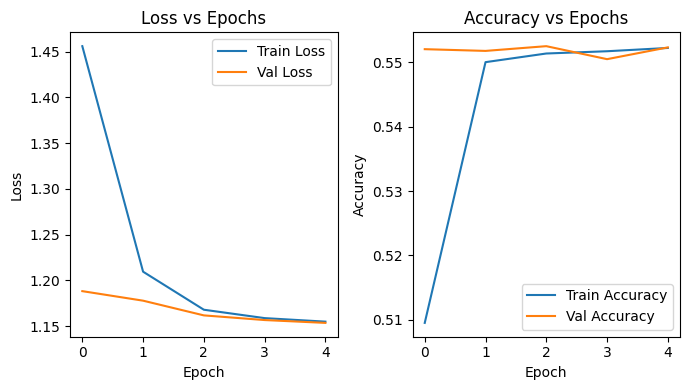


Testing Config: Hidden=128, Batch=16, LR=0.001, Epochs=5
Epoch 1/5, Train Loss: 1.3368, Train Accuracy: 0.5302, Val Loss: 1.1683, Val Accuracy: 0.5516
Epoch 2/5, Train Loss: 1.1600, Train Accuracy: 0.5518, Val Loss: 1.1554, Val Accuracy: 0.5524
Epoch 3/5, Train Loss: 1.1535, Train Accuracy: 0.5525, Val Loss: 1.1519, Val Accuracy: 0.5532
Epoch 4/5, Train Loss: 1.1509, Train Accuracy: 0.5523, Val Loss: 1.1497, Val Accuracy: 0.5518
Epoch 5/5, Train Loss: 1.1492, Train Accuracy: 0.5520, Val Loss: 1.1484, Val Accuracy: 0.5517


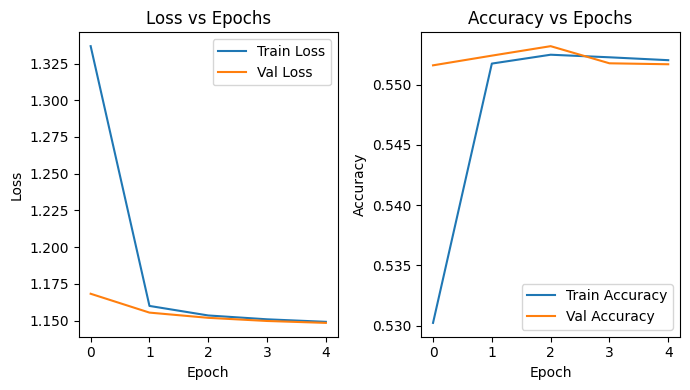


Testing Config: Hidden=64, Batch=16, LR=0.0005, Epochs=5
Epoch 1/5, Train Loss: 1.5520, Train Accuracy: 0.5037, Val Loss: 1.2347, Val Accuracy: 0.5512
Epoch 2/5, Train Loss: 1.2041, Train Accuracy: 0.5511, Val Loss: 1.1831, Val Accuracy: 0.5520
Epoch 3/5, Train Loss: 1.1734, Train Accuracy: 0.5516, Val Loss: 1.1668, Val Accuracy: 0.5494
Epoch 4/5, Train Loss: 1.1629, Train Accuracy: 0.5519, Val Loss: 1.1598, Val Accuracy: 0.5521
Epoch 5/5, Train Loss: 1.1576, Train Accuracy: 0.5524, Val Loss: 1.1558, Val Accuracy: 0.5520


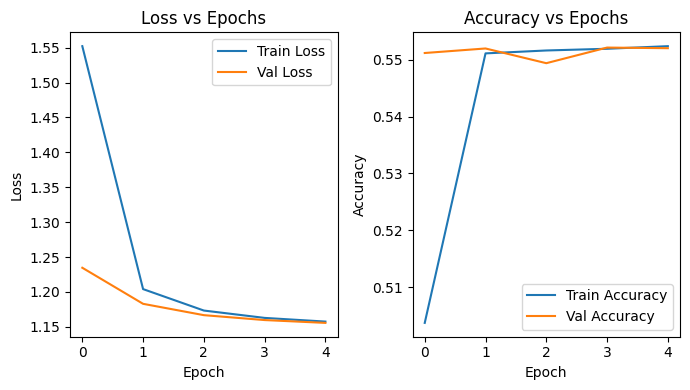


Testing Config: Hidden=64, Batch=32, LR=0.0005, Epochs=5
Epoch 1/5, Train Loss: 1.7880, Train Accuracy: 0.4959, Val Loss: 1.3525, Val Accuracy: 0.5474
Epoch 2/5, Train Loss: 1.2930, Train Accuracy: 0.5489, Val Loss: 1.2393, Val Accuracy: 0.5501
Epoch 3/5, Train Loss: 1.2034, Train Accuracy: 0.5515, Val Loss: 1.1821, Val Accuracy: 0.5517
Epoch 4/5, Train Loss: 1.1749, Train Accuracy: 0.5517, Val Loss: 1.1697, Val Accuracy: 0.5515
Epoch 5/5, Train Loss: 1.1665, Train Accuracy: 0.5517, Val Loss: 1.1639, Val Accuracy: 0.5518


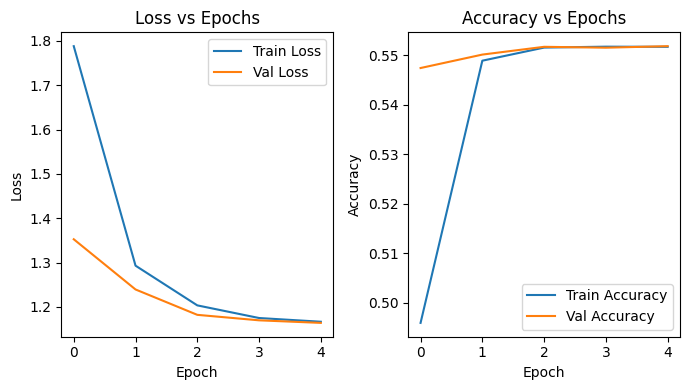


Testing Config: Hidden=64, Batch=16, LR=0.001, Epochs=5
Epoch 1/5, Train Loss: 1.3952, Train Accuracy: 0.5205, Val Loss: 1.1857, Val Accuracy: 0.5508
Epoch 2/5, Train Loss: 1.1678, Train Accuracy: 0.5514, Val Loss: 1.1588, Val Accuracy: 0.5517
Epoch 3/5, Train Loss: 1.1566, Train Accuracy: 0.5519, Val Loss: 1.1545, Val Accuracy: 0.5516
Epoch 4/5, Train Loss: 1.1527, Train Accuracy: 0.5520, Val Loss: 1.1514, Val Accuracy: 0.5527
Epoch 5/5, Train Loss: 1.1505, Train Accuracy: 0.5522, Val Loss: 1.1496, Val Accuracy: 0.5531


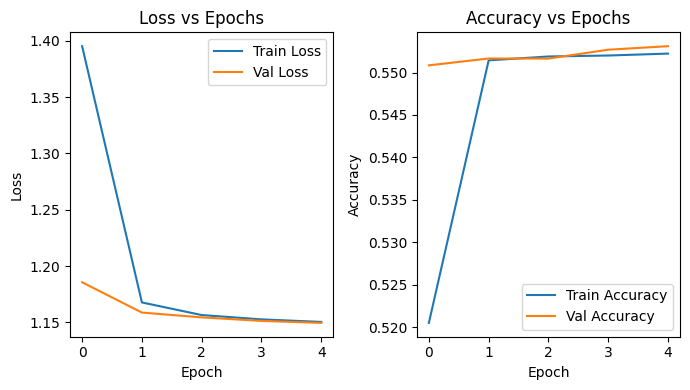


Testing Config: Hidden=64, Batch=32, LR=0.001, Epochs=5
Epoch 1/5, Train Loss: 1.6166, Train Accuracy: 0.4732, Val Loss: 1.2368, Val Accuracy: 0.5510
Epoch 2/5, Train Loss: 1.2251, Train Accuracy: 0.5500, Val Loss: 1.1939, Val Accuracy: 0.5514
Epoch 3/5, Train Loss: 1.1813, Train Accuracy: 0.5511, Val Loss: 1.1711, Val Accuracy: 0.5508
Epoch 4/5, Train Loss: 1.1666, Train Accuracy: 0.5516, Val Loss: 1.1630, Val Accuracy: 0.5524
Epoch 5/5, Train Loss: 1.1609, Train Accuracy: 0.5517, Val Loss: 1.1591, Val Accuracy: 0.5512


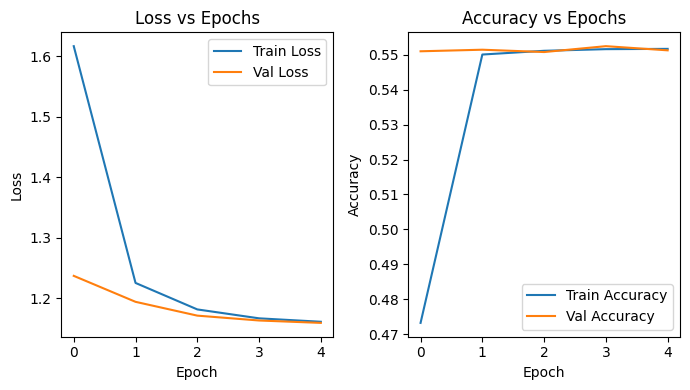


Testing Config: Hidden=128, Batch=32, LR=0.0005, Epochs=5
Epoch 1/5, Train Loss: 1.6303, Train Accuracy: 0.5208, Val Loss: 1.2673, Val Accuracy: 0.5503
Epoch 2/5, Train Loss: 1.2090, Train Accuracy: 0.5511, Val Loss: 1.1821, Val Accuracy: 0.5511
Epoch 3/5, Train Loss: 1.1969, Train Accuracy: 0.5513, Val Loss: 1.1750, Val Accuracy: 0.5518
Epoch 4/5, Train Loss: 1.2088, Train Accuracy: 0.5480, Val Loss: 1.1805, Val Accuracy: 0.5508
Epoch 5/5, Train Loss: 1.1724, Train Accuracy: 0.5518, Val Loss: 1.1669, Val Accuracy: 0.5518


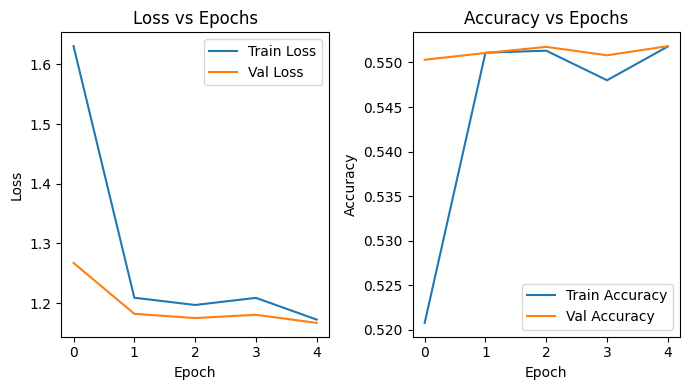


Testing Config: Hidden=128, Batch=32, LR=0.001, Epochs=5
Epoch 1/5, Train Loss: 1.4692, Train Accuracy: 0.5286, Val Loss: 1.1879, Val Accuracy: 0.5514
Epoch 2/5, Train Loss: 1.1782, Train Accuracy: 0.5516, Val Loss: 1.1644, Val Accuracy: 0.5512
Epoch 3/5, Train Loss: 1.2110, Train Accuracy: 0.5481, Val Loss: 1.1654, Val Accuracy: 0.5509
Epoch 4/5, Train Loss: 1.1613, Train Accuracy: 0.5517, Val Loss: 1.1584, Val Accuracy: 0.5517
Epoch 5/5, Train Loss: 1.1566, Train Accuracy: 0.5516, Val Loss: 1.1552, Val Accuracy: 0.5516


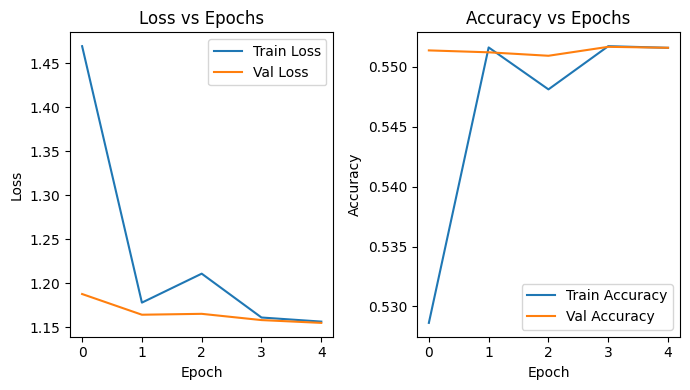


Best Hyperparameter Configuration: (128, 16, 0.001, 5)

Best Hyperparameters Selected. Training final model...
Epoch 1/5, Train Loss: 1.3294, Train Accuracy: 0.5319, Val Loss: 1.1643, Val Accuracy: 0.5504
Epoch 2/5, Train Loss: 1.2625, Train Accuracy: 0.5496, Val Loss: 1.1643, Val Accuracy: 0.5504
Epoch 3/5, Train Loss: 1.1593, Train Accuracy: 0.5518, Val Loss: 1.1561, Val Accuracy: 0.5530
Epoch 4/5, Train Loss: 1.1542, Train Accuracy: 0.5518, Val Loss: 1.1529, Val Accuracy: 0.5504
Epoch 5/5, Train Loss: 1.1519, Train Accuracy: 0.5521, Val Loss: 1.1512, Val Accuracy: 0.5524


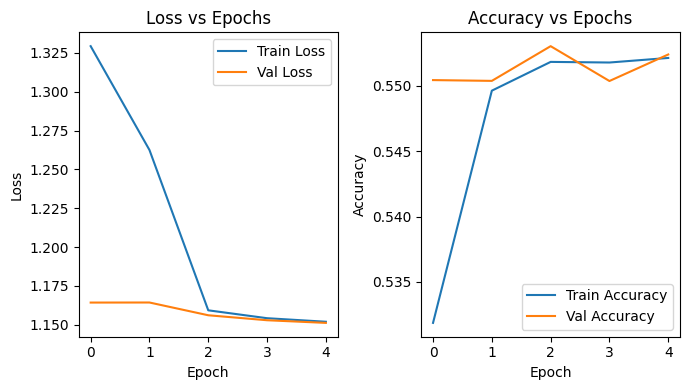


Final Training completed in 306.95 seconds!


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import time
import random
from torch.utils.data import DataLoader

#------------------------------------------------------
# PyTorch Benchmark
#---------------------------------------------------

def benchmark_pytorch(input_size, hidden_size, train_loader, val_loader, epochs, lr):
    model = LSTMPyTorch(input_size, hidden_size, output_size=input_size)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    #For plot
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    start_time = time.time()

    for epoch in range(epochs):
        total_loss = 0
        correct = 0
        total = 0

        # Training Phase
        model.train()
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            # Convert to one hot encoding for inputs
            inputs = nn.functional.one_hot(inputs, num_classes=input_size).float()

            optimizer.zero_grad()
            outputs = model(inputs)

            # Reshape outputs and targets for loss computation
            loss = criterion(outputs.view(-1, input_size), targets.view(-1))
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            # Compute accuracy
            predictions = outputs.argmax(dim=-1)
            correct += (predictions == targets).sum().item()
            total += targets.numel()

        train_accuracy = correct / total
        avg_train_loss = total_loss / len(train_loader)

        #Store for plot
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)

        # Validation Phase
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                inputs = nn.functional.one_hot(inputs, num_classes=input_size).float()
                outputs = model(inputs)
                loss = criterion(outputs.view(-1, input_size), targets.view(-1))
                val_loss += loss.item()
                predictions = outputs.argmax(dim=-1)
                val_correct += (predictions == targets).sum().item()
                val_total += targets.numel()

        val_accuracy = val_correct / val_total
        avg_val_loss = val_loss / len(val_loader)

        #Store for plot
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")
    plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies, epochs)
    return time.time() - start_time, avg_train_loss, avg_val_loss

# ------- Hyperparameter Search
def hyperparameter_search(train_loader, val_loader, num_combinations=15):
    param_space = {
        "hidden_size": [64, 128],
        "batch_size": [16, 32],
        "learning_rate": [0.001, 0.0005],
        "epochs": [5],
    }

    total_combinations = len(param_space["hidden_size"]) * len(param_space["batch_size"]) * len(param_space["learning_rate"]) * len(param_space["epochs"])
    num_combinations = min(num_combinations, total_combinations)
    sampled_configs = random.sample(
        [(h, b, lr, e) for h in param_space["hidden_size"]
                      for b in param_space["batch_size"]
                      for lr in param_space["learning_rate"]
                      for e in param_space["epochs"]], num_combinations)

    best_config = None
    best_loss = float("inf")

    for config in sampled_configs:
        h_size, b_size, lr, e = config
        print(f"\nTesting Config: Hidden={h_size}, Batch={b_size}, LR={lr}, Epochs={e}")

        train_loader, val_loader, _ = get_dataloader(sequence_length=100, batch_size=b_size)  # Adjust batch size
        training_time, final_loss, _ = benchmark_pytorch(input_size=12, hidden_size=h_size, train_loader=train_loader, val_loader=val_loader, epochs=e, lr=lr)

        if final_loss < best_loss:
            best_loss = final_loss
            best_config = config

    print(f"\nBest Hyperparameter Configuration: {best_config}")
    return best_config

# ------- Run Hyperparameter Search and Training with Validation
train_loader, val_loader, _ = get_dataloader(sequence_length=100, batch_size=32)  # Load train/val sets
print("\nSearching for Best Hyperparameters...")
best_hyperparams = hyperparameter_search(train_loader, val_loader, num_combinations=15)
print("\nBest Hyperparameters Selected. Training final model...")

best_h_size, best_b_size, best_lr, best_epochs = best_hyperparams
train_loader, val_loader, _ = get_dataloader(sequence_length=100, batch_size=best_b_size)
training_time, _, _ = benchmark_pytorch(input_size=12, hidden_size=best_h_size, train_loader=train_loader, val_loader=val_loader, epochs=best_epochs, lr=best_lr)
print(f"\nFinal Training completed in {training_time:.2f} seconds!")


## 4. Evaluation

In [7]:
from scipy.stats import sem
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

# ------- Model Evaluation
def evaluate_model(model, test_loader):
    model.eval()
    loss_fn = nn.CrossEntropyLoss()
    total_loss = 0
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x, batch_y = batch_x.to(model.fc.weight.device), batch_y.to(model.fc.weight.device)
            batch_x = nn.functional.one_hot(batch_x, num_classes=model.fc.out_features).float()

            predictions = model(batch_x)
            loss = loss_fn(predictions.view(-1, model.fc.out_features), batch_y.view(-1))
            total_loss += loss.item()

            predicted_labels = predictions.argmax(dim=-1)
            correct_predictions = (predicted_labels == batch_y).sum().item()
            total_correct += correct_predictions
            total_samples += batch_y.numel()

    accuracy = total_correct / total_samples
    avg_loss = total_loss / len(test_loader)
    return avg_loss, accuracy

# ------- Evaluation on Different T Values
def full_evaluation(model, dataset_class, sequence_lengths=[200, 500, 1000], trials=3):
    results = {}
    print("\nEvaluating best model on different T values...")

    trial_accuracies = {T: [] for T in sequence_lengths}

    for T in sequence_lengths:
        print(f"Testing on T={T}...")
        _, _, test_loader = get_dataloader(sequence_length=T, batch_size=best_b_size)

        for _ in range(trials):
            loss, accuracy = evaluate_model(model, test_loader)
            trial_accuracies[T].append(accuracy)

    # Compute mean and standard error
    results = {
        T: {
            "mean_accuracy": np.mean(trial_accuracies[T]),
            "std_error": sem(trial_accuracies[T])
        } for T in sequence_lengths
    }

    print("\nEvaluation Results:")
    for T, metrics in results.items():
        print(f"T={T}: Accuracy={metrics['mean_accuracy']:.4f} ± {metrics['std_error']:.4f}")

    return results

# ------- Run Evaluation
print("\nEvaluating the best model...")
_, _, test_loader = get_dataloader(sequence_length=100, batch_size=best_b_size)
evaluation_results = full_evaluation(
    LSTMPyTorch(input_size=12, hidden_size=best_h_size, output_size=12),
    CopyTaskDataset
)
print("\nEvaluation completed!")


Evaluating the best model...

Evaluating best model on different T values...
Testing on T=200...
Testing on T=500...
Testing on T=1000...

Evaluation Results:
T=200: Accuracy=0.0494 ± 0.0000
T=500: Accuracy=0.0501 ± 0.0000
T=1000: Accuracy=0.0502 ± 0.0000

Evaluation completed!


#  Multiplicative LSTM

## 1.Implementation of the model

In [8]:
import torch
import torch.nn as nn

#--------------------------------------------------------
# PyTorch Implementation of Multiplicative LSTM
#------------------------------------------------------

# ------- Single-Step Multiplicative LSTM Cell
class MLSTMCellPyTorch(nn.Module):
    """
    A single-step Multiplicative LSTM cell in PyTorch
    """
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size

        # Multiplicative transformation
        self.W_m = nn.Linear(input_size + hidden_size, input_size)

        self.W_i = nn.Linear(input_size + hidden_size, hidden_size)  # Input gate
        self.W_f = nn.Linear(input_size + hidden_size, hidden_size)  # Forget gate
        self.W_o = nn.Linear(input_size + hidden_size, hidden_size)  # Output gate
        self.W_c = nn.Linear(input_size + hidden_size, hidden_size)  # Candidate cell state

    def forward(self, x_t, h_prev, c_prev):
        """
        x_t: [batch_size, input_size]
        h_prev: [batch_size, hidden_size]
        c_prev: [batch_size, hidden_size]
        """
        # Compute multiplicative transformation
        m_t = torch.sigmoid(self.W_m(torch.cat((x_t, h_prev), dim=1)))
        x_t = x_t * m_t

        combined = torch.cat((x_t, h_prev), dim=1)

        i_t = torch.sigmoid(self.W_i(combined))
        f_t = torch.sigmoid(self.W_f(combined))
        o_t = torch.sigmoid(self.W_o(combined))
        c_tilde = torch.tanh(self.W_c(combined))

        c_t = f_t * c_prev + i_t * c_tilde  # Cell state update
        h_t = o_t * torch.tanh(c_t)  # Hidden state update

        return h_t, c_t

# ------- Higher-level PyTorch MLSTM that unrolls over time
class MLSTMPyTorch(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.lstm_cell = MLSTMCellPyTorch(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)  # Output projection

    def forward(self, X):
        """
        X: [batch_size, seq_length, input_size]
        """
        batch_size, seq_len, _ = X.shape
        h_t = torch.zeros(batch_size, self.hidden_size, device=X.device)
        c_t = torch.zeros(batch_size, self.hidden_size, device=X.device)

        outputs = []
        for t in range(seq_len):
            h_t, c_t = self.lstm_cell(X[:, t, :], h_t, c_t)
            outputs.append(self.fc(h_t).unsqueeze(1))

        return torch.cat(outputs, dim=1)


## 3. Model Training


Benchmarking MLSTM with Best Hyperparameters...
Epoch 1/5, Train Loss: 1.4687, Train Accuracy: 0.5227, Val Loss: 1.2057, Val Accuracy: 0.5499
Epoch 2/5, Train Loss: 1.1872, Train Accuracy: 0.5506, Val Loss: 1.1748, Val Accuracy: 0.5503
Epoch 3/5, Train Loss: 1.1688, Train Accuracy: 0.5517, Val Loss: 1.1643, Val Accuracy: 0.5519
Epoch 4/5, Train Loss: 1.1618, Train Accuracy: 0.5516, Val Loss: 1.1598, Val Accuracy: 0.5505
Epoch 5/5, Train Loss: 1.1580, Train Accuracy: 0.5515, Val Loss: 1.1564, Val Accuracy: 0.5525


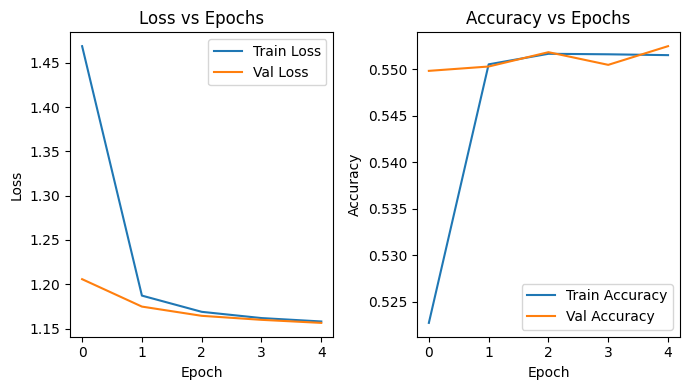


MLSTM Training completed in 412.52 seconds!


In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import time
from torch.utils.data import DataLoader

#---------------------------------------------------
# PyTorch Benchmark for MLSTM Training with Validation
#---------------------------------------------------

def benchmark_pytorch(input_size, hidden_size, train_loader, val_loader, epochs, lr):
    model = MLSTMPyTorch(input_size, hidden_size, output_size=input_size)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    start_time = time.time()

    for epoch in range(epochs):
        total_loss = 0
        correct = 0
        total = 0

        # Training Phase
        model.train()
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            # Convert to one-hot encoding for inputs
            inputs = nn.functional.one_hot(inputs, num_classes=input_size).float()

            optimizer.zero_grad()
            outputs = model(inputs)

            # Reshape outputs and targets for loss computation
            loss = criterion(outputs.view(-1, input_size), targets.view(-1))
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            # Compute accuracy
            predictions = outputs.argmax(dim=-1)
            correct += (predictions == targets).sum().item()
            total += targets.numel()

        train_accuracy = correct / total
        avg_train_loss = total_loss / len(train_loader)

        #Store for plot
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)

        # Validation Phase
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                inputs = nn.functional.one_hot(inputs, num_classes=input_size).float()
                outputs = model(inputs)
                loss = criterion(outputs.view(-1, input_size), targets.view(-1))
                val_loss += loss.item()
                predictions = outputs.argmax(dim=-1)
                val_correct += (predictions == targets).sum().item()
                val_total += targets.numel()

        val_accuracy = val_correct / val_total
        avg_val_loss = val_loss / len(val_loader)

        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")
    plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies, epochs)
    return time.time() - start_time, avg_train_loss, avg_val_loss

# ------- Run Benchmark for MLSTM with Best Hyperparameters
train_loader, val_loader, _ = get_dataloader(sequence_length=100, batch_size=best_b_size)
print("\nBenchmarking MLSTM with Best Hyperparameters...")

training_time, _, _ = benchmark_pytorch(
    input_size=12,
    hidden_size=best_h_size,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=best_epochs,
    lr=best_lr
)

print(f"\nMLSTM Training completed in {training_time:.2f} seconds!")


## 4. Model Evaluation

In [11]:
from scipy.stats import sem
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

# ------- Model Evaluation for MLSTM
def evaluate_model(model, test_loader):
    model.eval()
    loss_fn = nn.CrossEntropyLoss()
    total_loss = 0
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x, batch_y = batch_x.to(model.fc.weight.device), batch_y.to(model.fc.weight.device)
            batch_x = nn.functional.one_hot(batch_x, num_classes=model.fc.out_features).float()

            predictions = model(batch_x)
            loss = loss_fn(predictions.view(-1, model.fc.out_features), batch_y.view(-1))
            total_loss += loss.item()

            predicted_labels = predictions.argmax(dim=-1)
            correct_predictions = (predicted_labels == batch_y).sum().item()
            total_correct += correct_predictions
            total_samples += batch_y.numel()

    accuracy = total_correct / total_samples
    avg_loss = total_loss / len(test_loader)
    return avg_loss, accuracy

# ------- Full Evaluation on Different T Values for MLSTM
def full_evaluation(model, dataset_class, sequence_lengths=[200, 500, 1000], trials=3):
    results = {}
    print("\nEvaluating best MLSTM model on different T values...")

    trial_accuracies = {T: [] for T in sequence_lengths}

    for T in sequence_lengths:
        print(f"Testing on T={T}...")
        _, _, test_loader = get_dataloader(sequence_length=T, batch_size=best_b_size)

        for _ in range(trials):
            loss, accuracy = evaluate_model(model, test_loader)
            trial_accuracies[T].append(accuracy)

    # Compute mean and standard error
    results = {
        T: {
            "mean_accuracy": np.mean(trial_accuracies[T]),
            "std_error": sem(trial_accuracies[T])
        } for T in sequence_lengths
    }

    print("\nEvaluation Results:")
    for T, metrics in results.items():
        print(f"T={T}: Accuracy={metrics['mean_accuracy']:.4f} ± {metrics['std_error']:.4f}")

    return results

# ------- Run Evaluation for MLSTM
print("\nEvaluating the best MLSTM model...")
_, _, test_loader = get_dataloader(sequence_length=100, batch_size=best_b_size)
evaluation_results = full_evaluation(
    MLSTMPyTorch(input_size=12, hidden_size=best_h_size, output_size=12),
    CopyTaskDataset
)
print("\nEvaluation completed!")



Evaluating the best MLSTM model...

Evaluating best MLSTM model on different T values...
Testing on T=200...
Testing on T=500...
Testing on T=1000...

Evaluation Results:
T=200: Accuracy=0.0498 ± 0.0000
T=500: Accuracy=0.0496 ± 0.0000
T=1000: Accuracy=0.0501 ± 0.0000

Evaluation completed!


# Standard GRU

## 1.Implementation of the model

In [12]:
import torch
import torch.nn as nn

#----------------------------------------
# PyTorch Implementation of Standard GRU
#----------------------------------------

# ------- Single-Step GRU Cell
class GRUCellPyTorch(nn.Module):
    """
    A single-step GRU cell in PyTorch.
    Implements the standard GRU equations from the provided document.
    """
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size


        self.W_z = nn.Linear(input_size, hidden_size)  # Update gate weights for input
        self.U_z = nn.Linear(hidden_size, hidden_size)  # Update gate weights for hidden state
        self.W_r = nn.Linear(input_size, hidden_size)  # Reset gate weights for input
        self.U_r = nn.Linear(hidden_size, hidden_size)  # Reset gate weights for hidden state
        self.W_h = nn.Linear(input_size, hidden_size)  # Candidate hidden state weights for input
        self.U_h = nn.Linear(hidden_size, hidden_size)  # Candidate hidden state weights for hidden state

    def forward(self, x_t, h_prev):
        """
        x_t: [batch_size, input_size]
        h_prev: [batch_size, hidden_size]
        """
        z_t = torch.sigmoid(self.W_z(x_t) + self.U_z(h_prev))
        r_t = torch.sigmoid(self.W_r(x_t) + self.U_r(h_prev))
        h_tilde = torch.tanh(self.W_h(x_t) + self.U_h(r_t * h_prev))

        h_t = (1 - z_t) * h_prev + z_t * h_tilde

        return h_t

# ------- Higher-level PyTorch GRU that unrolls over time
class GRUPyTorch(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.gru_cell = GRUCellPyTorch(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, X):
        """
        X: [batch_size, seq_length, input_size]
        """
        batch_size, seq_len, _ = X.shape
        h_t = torch.zeros(batch_size, self.hidden_size, device=X.device)

        outputs = []
        for t in range(seq_len):
            h_t = self.gru_cell(X[:, t, :], h_t)
            outputs.append(self.fc(h_t).unsqueeze(1))

        return torch.cat(outputs, dim=1)


## 3. Model Training

Training with Validation


Benchmarking Standard GRU with Best Hyperparameters...
Epoch 1/5, Train Loss: 1.2628, Train Accuracy: 0.5375, Val Loss: 1.1548, Val Accuracy: 0.5518
Epoch 2/5, Train Loss: 1.1524, Train Accuracy: 0.5523, Val Loss: 1.1504, Val Accuracy: 0.5522
Epoch 3/5, Train Loss: 1.1493, Train Accuracy: 0.5519, Val Loss: 1.1479, Val Accuracy: 0.5519
Epoch 4/5, Train Loss: 1.1477, Train Accuracy: 0.5521, Val Loss: 1.1474, Val Accuracy: 0.5523
Epoch 5/5, Train Loss: 1.1470, Train Accuracy: 0.5522, Val Loss: 1.1468, Val Accuracy: 0.5517


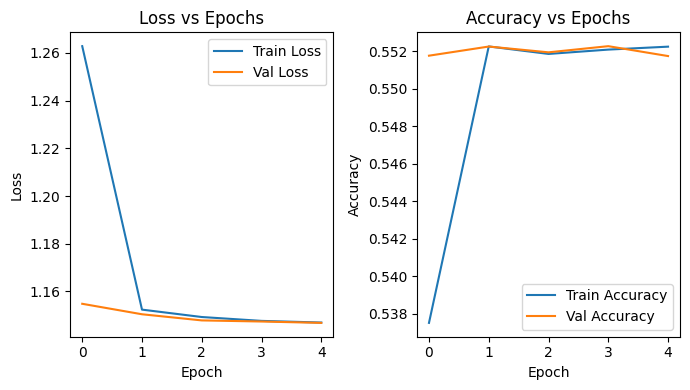


Standard GRU Training completed in 395.42 seconds!


In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
import time
from torch.utils.data import DataLoader

########################################
# PyTorch Benchmark Standard GRU
########################################

def benchmark_pytorch(input_size, hidden_size, train_loader, val_loader, epochs, lr):
    model = GRUPyTorch(input_size, hidden_size, output_size=input_size)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    start_time = time.time()

    for epoch in range(epochs):
        total_loss = 0
        correct = 0
        total = 0

        # Training Phase
        model.train()
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            # Convert to one-hot encoding for inputs
            inputs = nn.functional.one_hot(inputs, num_classes=input_size).float()

            optimizer.zero_grad()
            outputs = model(inputs)

            # Reshape outputs and targets for loss computation
            loss = criterion(outputs.view(-1, input_size), targets.view(-1))
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            # Compute accuracy
            predictions = outputs.argmax(dim=-1)
            correct += (predictions == targets).sum().item()
            total += targets.numel()

        train_accuracy = correct / total
        avg_train_loss = total_loss / len(train_loader)

        #For plot
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)

        # Validation Phase
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                inputs = nn.functional.one_hot(inputs, num_classes=input_size).float()
                outputs = model(inputs)
                loss = criterion(outputs.view(-1, input_size), targets.view(-1))
                val_loss += loss.item()
                predictions = outputs.argmax(dim=-1)
                val_correct += (predictions == targets).sum().item()
                val_total += targets.numel()

        val_accuracy = val_correct / val_total
        avg_val_loss = val_loss / len(val_loader)

        #For plot
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")
    plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies, epochs)
    return time.time() - start_time, avg_train_loss, avg_val_loss

# ------- Run Benchmark for Standard GRU with Best Hyperparameters
train_loader, val_loader, _ = get_dataloader(sequence_length=100, batch_size=best_b_size)
print("\nBenchmarking Standard GRU with Best Hyperparameters...")

training_time, _, _ = benchmark_pytorch(
    input_size=12,
    hidden_size=best_h_size,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=best_epochs,
    lr=best_lr
)

print(f"\nStandard GRU Training completed in {training_time:.2f} seconds!")

## 4. Evaluation

In [15]:
from scipy.stats import sem
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

# ------- Model Evaluation for Standard GRU
def evaluate_model(model, test_loader):
    model.eval()
    loss_fn = nn.CrossEntropyLoss()
    total_loss = 0
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x, batch_y = batch_x.to(model.fc.weight.device), batch_y.to(model.fc.weight.device)
            batch_x = nn.functional.one_hot(batch_x, num_classes=model.fc.out_features).float()

            predictions = model(batch_x)
            loss = loss_fn(predictions.view(-1, model.fc.out_features), batch_y.view(-1))
            total_loss += loss.item()

            predicted_labels = predictions.argmax(dim=-1)
            correct_predictions = (predicted_labels == batch_y).sum().item()
            total_correct += correct_predictions
            total_samples += batch_y.numel()

    accuracy = total_correct / total_samples
    avg_loss = total_loss / len(test_loader)
    return avg_loss, accuracy

# ------- Full Evaluation on Different T Values for Standard GRU
def full_evaluation(model, dataset_class, sequence_lengths=[200, 500, 1000], trials=3):
    results = {}
    print("\nEvaluating best Standard GRU model on different T values...")

    trial_accuracies = {T: [] for T in sequence_lengths}

    for T in sequence_lengths:
        print(f"Testing on T={T}...")
        _, _, test_loader = get_dataloader(sequence_length=T, batch_size=best_b_size)

        for _ in range(trials):
            loss, accuracy = evaluate_model(model, test_loader)
            trial_accuracies[T].append(accuracy)

    # Compute mean and standard error
    results = {
        T: {
            "mean_accuracy": np.mean(trial_accuracies[T]),
            "std_error": sem(trial_accuracies[T])
        } for T in sequence_lengths
    }

    print("\nEvaluation Results:")
    for T, metrics in results.items():
        print(f"T={T}: Accuracy={metrics['mean_accuracy']:.4f} ± {metrics['std_error']:.4f}")

    return results

# ------- Run Evaluation for Standard GRU
print("\nEvaluating the best Standard GRU model...")
_, _, test_loader = get_dataloader(sequence_length=100, batch_size=best_b_size)
evaluation_results = full_evaluation(
    GRUPyTorch(input_size=12, hidden_size=best_h_size, output_size=12),
    CopyTaskDataset
)
print("\nEvaluation completed!")



Evaluating the best Standard GRU model...

Evaluating best Standard GRU model on different T values...
Testing on T=200...
Testing on T=500...
Testing on T=1000...

Evaluation Results:
T=200: Accuracy=0.0503 ± 0.0000
T=500: Accuracy=0.0502 ± 0.0000
T=1000: Accuracy=0.0500 ± 0.0000

Evaluation completed!


# Multiplicative GRU

## 1.Implementation of the model

In [16]:
import torch
import torch.nn as nn

#----------------------------------------------
# PyTorch Implementation of Multiplicative GRU
#----------------------------------------------

# ------- Single Step Multiplicative GRU Cell
class MGRUCellPyTorch(nn.Module):
    """
    A single-step Multiplicative GRU cell in PyTorch.
    Implements the MGRU equations from the provided document.
    """
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size

        # Multiplicative transformation
        self.W_m = nn.Linear(input_size + hidden_size, input_size)

        self.W_z = nn.Linear(input_size, hidden_size)  # Update gate weights for input
        self.U_z = nn.Linear(hidden_size, hidden_size)  # Update gate weights for hidden state
        self.W_r = nn.Linear(input_size, hidden_size)  # Reset gate weights for input
        self.U_r = nn.Linear(hidden_size, hidden_size)  # Reset gate weights for hidden state
        self.W_h = nn.Linear(input_size, hidden_size)  # Candidate hidden state weights for input
        self.U_h = nn.Linear(hidden_size, hidden_size)  # Candidate hidden state weights for hidden state

    def forward(self, x_t, h_prev):
        """
        x_t: [batch_size, input_size]
        h_prev: [batch_size, hidden_size]
        """
        # Compute multiplicative transformation
        m_t = torch.sigmoid(self.W_m(torch.cat((x_t, h_prev), dim=1)))
        x_t = x_t * m_t

        z_t = torch.sigmoid(self.W_z(x_t) + self.U_z(h_prev))
        r_t = torch.sigmoid(self.W_r(x_t) + self.U_r(h_prev))
        h_tilde = torch.tanh(self.W_h(x_t) + self.U_h(r_t * h_prev))

        h_t = (1 - z_t) * h_prev + z_t * h_tilde

        return h_t

# ------- Higher-level PyTorch MGRU that unrolls over time
class MGRUPyTorch(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.gru_cell = MGRUCellPyTorch(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, X):
        """
        X: [batch_size, seq_length, input_size]
        """
        batch_size, seq_len, _ = X.shape
        h_t = torch.zeros(batch_size, self.hidden_size, device=X.device)

        outputs = []
        for t in range(seq_len):
            h_t = self.gru_cell(X[:, t, :], h_t)
            outputs.append(self.fc(h_t).unsqueeze(1))

        return torch.cat(outputs, dim=1)


## 3. Model Training

Training with Validation


Benchmarking Multiplicative GRU with Best Hyperparameters...
Epoch 1/5, Train Loss: 1.2568, Train Accuracy: 0.5437, Val Loss: 1.1547, Val Accuracy: 0.5515
Epoch 2/5, Train Loss: 1.1520, Train Accuracy: 0.5523, Val Loss: 1.1501, Val Accuracy: 0.5531
Epoch 3/5, Train Loss: 1.1489, Train Accuracy: 0.5518, Val Loss: 1.1478, Val Accuracy: 0.5523
Epoch 4/5, Train Loss: 1.1475, Train Accuracy: 0.5520, Val Loss: 1.1469, Val Accuracy: 0.5531
Epoch 5/5, Train Loss: 1.1468, Train Accuracy: 0.5525, Val Loss: 1.1466, Val Accuracy: 0.5518


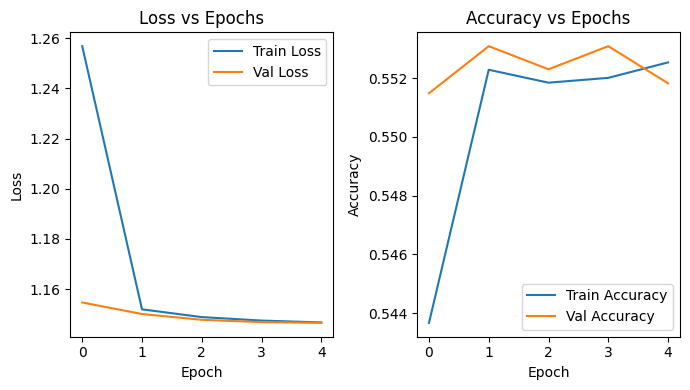


Multiplicative GRU Training completed in 492.04 seconds!


In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
import time
from torch.utils.data import DataLoader

#------------------------------------------
# PyTorch Benchmark for Multiplicative GRU
#-----------------------------------------

def benchmark_pytorch(input_size, hidden_size, train_loader, val_loader, epochs, lr):
    model = MGRUPyTorch(input_size, hidden_size, output_size=input_size)  # Ensure output matches input size
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    start_time = time.time()

    for epoch in range(epochs):
        total_loss = 0
        correct = 0
        total = 0

        # Training Phase
        model.train()
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            # Convert to one-hot encoding for inputs
            inputs = nn.functional.one_hot(inputs, num_classes=input_size).float()

            optimizer.zero_grad()
            outputs = model(inputs)

            # Reshape outputs and targets for loss computation
            loss = criterion(outputs.view(-1, input_size), targets.view(-1))
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            # Compute accuracy
            predictions = outputs.argmax(dim=-1)
            correct += (predictions == targets).sum().item()
            total += targets.numel()

        train_accuracy = correct / total
        avg_train_loss = total_loss / len(train_loader)

        #For plot
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)

        # Validation Phase
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                inputs = nn.functional.one_hot(inputs, num_classes=input_size).float()
                outputs = model(inputs)
                loss = criterion(outputs.view(-1, input_size), targets.view(-1))
                val_loss += loss.item()
                predictions = outputs.argmax(dim=-1)
                val_correct += (predictions == targets).sum().item()
                val_total += targets.numel()

        val_accuracy = val_correct / val_total
        avg_val_loss = val_loss / len(val_loader)

        #For plot
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")
    plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies, epochs)
    return time.time() - start_time, avg_train_loss, avg_val_loss

# ------- Run Benchmark for Multiplicative GRU with Best Hyperparameters -------
train_loader, val_loader, _ = get_dataloader(sequence_length=100, batch_size=best_b_size)  # Use best batch size
print("\nBenchmarking Multiplicative GRU with Best Hyperparameters...")

training_time, _, _ = benchmark_pytorch(
    input_size=12,
    hidden_size=best_h_size,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=best_epochs,
    lr=best_lr
)

print(f"\nMultiplicative GRU Training completed in {training_time:.2f} seconds!")


## 4. Model Evaluation

In [18]:
from scipy.stats import sem
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

# ------- Model Evaluation for Multiplicative GRU
def evaluate_model(model, test_loader):
    model.eval()
    loss_fn = nn.CrossEntropyLoss()
    total_loss = 0
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x, batch_y = batch_x.to(model.fc.weight.device), batch_y.to(model.fc.weight.device)
            batch_x = nn.functional.one_hot(batch_x, num_classes=model.fc.out_features).float()

            predictions = model(batch_x)
            loss = loss_fn(predictions.view(-1, model.fc.out_features), batch_y.view(-1))
            total_loss += loss.item()

            predicted_labels = predictions.argmax(dim=-1)
            correct_predictions = (predicted_labels == batch_y).sum().item()
            total_correct += correct_predictions
            total_samples += batch_y.numel()

    accuracy = total_correct / total_samples
    avg_loss = total_loss / len(test_loader)
    return avg_loss, accuracy

# ------- Full Evaluation on Different T Values for Multiplicative GRU
def full_evaluation(model, dataset_class, sequence_lengths=[100, 200, 500, 1000], trials=3):
    results = {}
    print("\nEvaluating best Multiplicative GRU model on different T values...")

    trial_accuracies = {T: [] for T in sequence_lengths}

    for T in sequence_lengths:
        print(f"Testing on T={T}...")
        _, _, test_loader = get_dataloader(sequence_length=T, batch_size=best_b_size)

        for _ in range(trials):
            loss, accuracy = evaluate_model(model, test_loader)
            trial_accuracies[T].append(accuracy)

    # Compute mean and standard error
    results = {
        T: {
            "mean_accuracy": np.mean(trial_accuracies[T]),
            "std_error": sem(trial_accuracies[T])
        } for T in sequence_lengths
    }

    print("\nEvaluation Results:")
    for T, metrics in results.items():
        print(f"T={T}: Accuracy={metrics['mean_accuracy']:.4f} ± {metrics['std_error']:.4f}")

    return results

# ------- Run Evaluation for Multiplicative GRU -------
print("\nEvaluating the best Multiplicative GRU model...")
_, _, test_loader = get_dataloader(sequence_length=100, batch_size=best_b_size)
evaluation_results = full_evaluation(
    MGRUPyTorch(input_size=12, hidden_size=best_h_size, output_size=12),
    CopyTaskDataset
)
print("\nEvaluation completed!")



Evaluating the best Multiplicative GRU model...

Evaluating best Multiplicative GRU model on different T values...
Testing on T=100...
Testing on T=200...
Testing on T=500...
Testing on T=1000...

Evaluation Results:
T=100: Accuracy=0.0500 ± 0.0000
T=200: Accuracy=0.0503 ± 0.0000
T=500: Accuracy=0.0495 ± 0.0000
T=1000: Accuracy=0.0501 ± 0.0000

Evaluation completed!
